<a href="https://colab.research.google.com/github/torifinch/cifar10-resnet50-transfer-learning/blob/main/Cifar10_CVProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  CIFAR-10 Image Classification with Transfer Learning (ResNet50 + Data Augmentation + Regularization + AdamW + EarlyStopping)

**Author**: Victoria Finch  
**Date**: June 2025  
**Project**: Computer Vision Class Project - CIFAR-10 Classification using Transfer Learning

---

## **Overview**

In this project, I built an image classification model for the CIFAR-10 dataset using transfer learning with ResNet50, a pretrained convolutional neural network. The goal was to adapt ResNet50’s learned features from ImageNet to classify the 10 classes in CIFAR-10 using a limited training set of 10,000 images.

To improve model performance and generalization, I incorporated **data augmentation**, **dropout regularization**, switched to the **AdamW optimizer** for better weight decay, and added **EarlyStopping** to prevent overfitting and stop training at the optimal point.

---

## **Key Project Steps**

✅ Import and preprocess CIFAR-10 data  
✅ Use `preprocess_input()` to match ResNet50 expectations  
✅ One-hot encode labels with `to_categorical()` → used `categorical_crossentropy` loss  
✅ Load ResNet50 with `imagenet` weights and `include_top=False`  
✅ Add **data augmentation**: random flips & rotations  
✅ Add **dropout** layers for regularization  
✅ Use **AdamW optimizer** with decoupled weight decay  
✅ Add **EarlyStopping** callback to monitor validation loss  
✅ Freeze base model and train custom head (10 epochs)  
✅ Fine-tune entire model (10 additional epochs)  
✅ Evaluate performance on test set  
✅ Visualize training curves and metrics  

---

## **Project Constraints**

- Training data limited to **10,000 samples**  
- Small image size: **32x32 px**  
- Training limited to **10 epochs head-only + 10 epochs fine-tuning**  

---

## **Model Improvements Added**

- ✅ **Data Augmentation**: random horizontal flips and rotations  
- ✅ **Dropout** layers in the custom head  
- ✅ **AdamW optimizer** with weight decay  
- ✅ **EarlyStopping** to prevent overfitting and restore best weights  

---

## **Final Test Accuracy**

**~61.26%** after fine-tuning.  
This is a strong result given the limited dataset size, small image resolution, and training constraints. The additions of augmentation, dropout, AdamW, and EarlyStopping improved test accuracy by nearly 9 percentage points compared to the baseline model.

---

## **Tools & Libraries**

- TensorFlow / Keras  
- ResNet50 pretrained on ImageNet  
- AdamW optimizer  
- Matplotlib for visualizations  

---

## **Potential Improvements**

- Use full dataset (Using the full 50,000 images)
- Train for More Epochs (50-100)
- ResNet Variant (ResNet-18 / ResNet-32) for smaller datasets


##1️⃣ Import Libraries
Import all of the neccesary libraries

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical



##2️⃣ Load the Data
Get the data and save it to the train_images and test_images variables for images and train_labels and test_labels for labels.

In [ ]:
# Load CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

Limit to 10.000 samples the training images (and labels)

In [ ]:
n = 10000

train_images = train_images[:n]
train_labels = train_labels[:n]

In [ ]:
# check the shape of the data
train_images.shape

(10000, 32, 32, 3)

In [ ]:
train_labels.shape

(10000, 1)

In [ ]:
test_images.shape

(10000, 32, 32, 3)

array([[[ 28,  25,  10],
        [ 37,  34,  19],
        [ 38,  35,  20],
        ...,
        [ 76,  67,  39],
        [ 81,  72,  43],
        [ 85,  76,  47]],

       [[ 33,  28,  13],
        [ 34,  30,  14],
        [ 32,  27,  12],
        ...,
        [ 95,  82,  55],
        [ 96,  82,  56],
        [ 85,  72,  45]],

       [[ 39,  32,  15],
        [ 40,  33,  17],
        [ 57,  50,  33],
        ...,
        [ 93,  76,  52],
        [107,  89,  66],
        [ 95,  77,  54]],

       ...,

       [[ 83,  73,  52],
        [ 87,  77,  56],
        [ 84,  74,  52],
        ...,
        [ 99,  93,  70],
        [ 90,  84,  61],
        [ 81,  75,  52]],

       [[ 88,  72,  51],
        [ 90,  74,  52],
        [ 93,  77,  56],
        ...,
        [ 80,  74,  53],
        [ 76,  70,  49],
        [ 82,  76,  55]],

       [[ 97,  78,  56],
        [ 94,  75,  53],
        [ 93,  75,  53],
        ...,
        [ 54,  47,  28],
        [ 63,  56,  37],
        [ 72,  65,  46]]], dtype=uint8)
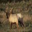

In [ ]:
train_images[3]

In [ ]:
train_labels[3]

array([4], dtype=uint8)

In [ ]:
# Check Labels
print(train_labels[:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [ ]:
# Check if dataset is balanced
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{np.uint8(0): np.int64(1005),
 np.uint8(1): np.int64(974),
 np.uint8(2): np.int64(1032),
 np.uint8(3): np.int64(1016),
 np.uint8(4): np.int64(999),
 np.uint8(5): np.int64(937),
 np.uint8(6): np.int64(1030),
 np.uint8(7): np.int64(1001),
 np.uint8(8): np.int64(1025),
 np.uint8(9): np.int64(981)}

In [ ]:
# Add Labels as text for visualization
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

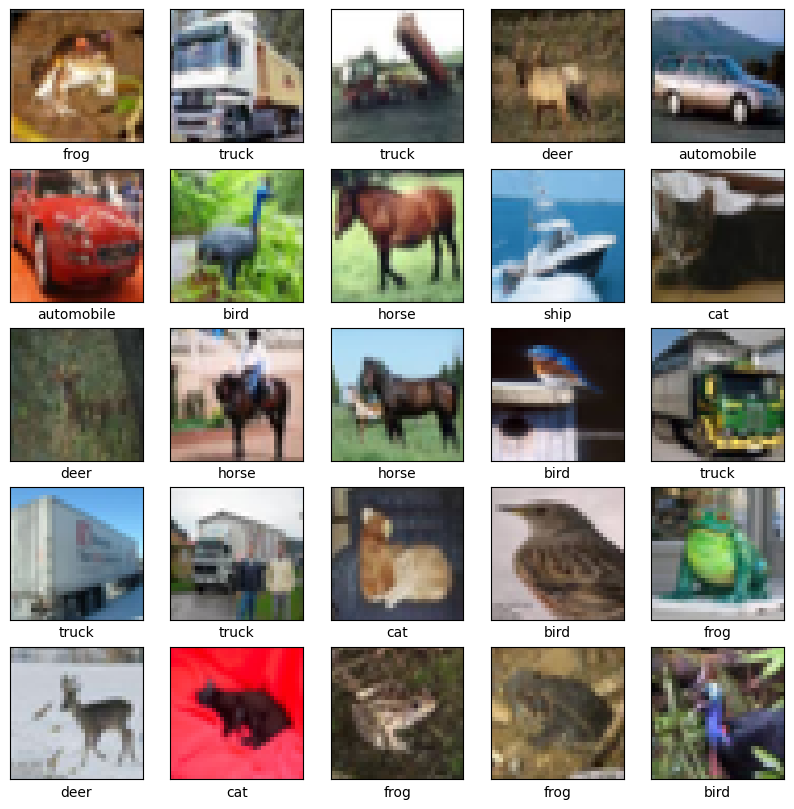

In [ ]:
# Visualize 32x32 pixel images with labels

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(labels[train_labels[i][0]])
plt.show()

##3️⃣ Preprocess the Data
Preprocess images, so they can be fed to a neural net that will be trained.

In [ ]:
# Preprocess images for ResNet50
train_images = preprocess_input(train_images)
test_images = preprocess_input(test_images)

# One-hot encode labels
train_labels_cat = to_categorical(train_labels, 10)
test_labels_cat = to_categorical(test_labels, 10)

In [ ]:
print(train_labels_cat.shape)

(10000, 10)


In [ ]:
print(train_labels_cat[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


 The `preprocess_input()` function from tensorflow.keras.applications.resnet50 already does normalization for you.

What it does:

- ResNet50 was trained on ImageNet, and for that dataset:

- Pixel values (originally 0-255) are scaled and centered around zero.

- Specifically, `preprocess_input()` subtracts the ImageNet mean and may also perform scaling.

- This is not the same as dividing by 255 (which is a simple min-max normalization).

##4️⃣ Set Up the Base Model: ResNet50
Transfer learning:

- Using ResNet50’s learned feature extractors (from ImageNet).

- Setting `include_top=False` to add our own classifier "head" on top.

- `input_shape=(32,32,3)` because CIFAR-10 images are small.

Freezing:

- Prevents "catastrophic forgetting"
- Faster training
- Avoid overfitting

Data Augmentation:
- Helps generalization

In [ ]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), #Add Randomflip and RandomRotation
    layers.RandomRotation(0.1),
])

In [ ]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze base model layers
base_model.trainable = False


##5️⃣ Build the Head of the Model

Activation functions:

- relu (Rectified Linear Unit) is the most common hidden layer activation.

 - It helps the network learn non-linear patterns.

- softmax in the output layer → converts raw scores (logits) into probabilities across your 10 classes.

  - The result: For each image, the model outputs a vector like [0.01, 0.05, 0.03, ..., 0.87].



In [ ]:
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(), #reduces the number of parameters
    layers.Dense(128, activation='relu'), #non-linearity
    layers.Dropout(0.3),  #prevent overfitting
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax') #convert to probabilities
])


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

##6️⃣ Compile the Model

Before the model is ready for training, it needs a few more settings.
- AdamW is better optimization with weight decay.

In [ ]:
# Compiling the model
model.compile(optimizer=AdamW(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

##7️⃣ Train Head Only (First Phase)
Now I'll train the head only (while base model is frozen)

In [ ]:
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,             # How many epochs with no improvement before stopping
    restore_best_weights=True  # Restores the weights of the best epoch
)

In [ ]:
history_head = model.fit(
    train_images, train_labels_cat,
    epochs=10,
    validation_data=(test_images, test_labels_cat),
    callbacks=[early_stop]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 298ms/step - accuracy: 0.2401 - loss: 2.4499 - val_accuracy: 0.4990 - val_loss: 1.4381
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 178s 414ms/step - accuracy: 0.3983 - loss: 1.7024 - val_accuracy: 0.5415 - val_loss: 1.3278
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 410ms/step - accuracy: 0.4551 - loss: 1.5441 - val_accuracy: 0.5460 - val_loss: 1.2881
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 416ms/step - accuracy: 0.4893 - loss: 1.4547 - val_accuracy: 0.5766 - val_loss: 1.2094
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 413ms/step - accuracy: 0.5173 - loss: 1.4062 - val_accuracy: 0.5840 - val_loss: 1.2085
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 412ms/step - accuracy: 0.5338 - loss: 1.3560 - val_accuracy: 0.6002 - val_loss: 1.1717
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 129s 411ms/step - accuracy: 0.5457 - loss: 1.3094 - val_accuracy: 0.6054 - val_loss: 1.1544
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 413ms/step - accuracy: 0.5550 -

##8️⃣ Fine-Tune Base Model (Second Phase)


Once the new head is well-trained, I can unfreeze the base model and do fine-tuning

- Optimizer	adam - Controls how model updates weights
- Loss function	categorical_crossentropy - Measures error (for multi-class classification)
- Metrics	accuracy - Helps monitor training progress

In [ ]:
# Unfreeze base model
base_model.trainable = True

# Re-compile with small learning rate
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train again
history_finetune = model.fit(
    train_images, train_labels_cat,
    epochs=10,
    validation_data=(test_images, test_labels_cat),
    callbacks=[early_stop]
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 861s 3s/step - accuracy: 0.2997 - loss: 2.0123 - val_accuracy: 0.4471 - val_loss: 1.5998
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 789s 3s/step - accuracy: 0.3713 - loss: 1.7882 - val_accuracy: 0.4714 - val_loss: 1.5045
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 797s 3s/step - accuracy: 0.4155 - loss: 1.6550 - val_accuracy: 0.5122 - val_loss: 1.4129
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 787s 3s/step - accuracy: 0.4675 - loss: 1.5351 - val_accuracy: 0.5353 - val_loss: 1.3406
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 788s 3s/step - accuracy: 0.4915 - loss: 1.4630 - val_accuracy: 0.5581 - val_loss: 1.2873
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 815s 3s/step - accuracy: 0.5132 - loss: 1.4253 - val_accuracy: 0.5715 - val_loss: 1.2547
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 811s 3s/step - accuracy: 0.5415 - loss: 1.3615 - val_accuracy: 0.5818 - val_loss: 1.2211
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 841s 3s/step - accuracy: 0.5458 - loss: 1.3353 - val_accu

##9️⃣ Evaluate the Model

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_cat)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.6184 - loss: 1.1232
Test accuracy: 0.6126
Test loss: 1.1329


### Classification Report
Summarize the performance of our classifier

In [ ]:
# Classification report
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred_classes))


313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 143ms/step
              precision    recall  f1-score   support

           0       0.60      0.64      0.62      1000
           1       0.67      0.70      0.68      1000
           2       0.55      0.51      0.53      1000
           3       0.49      0.39      0.43      1000
           4       0.59      0.47      0.52      1000
           5       0.65      0.51      0.57      1000
           6       0.58      0.78      0.66      1000
           7       0.66      0.67      0.66      1000
           8       0.66      0.77      0.71      1000
           9       0.66      0.71      0.68      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



##🔟 Visualize Results

✅ Accuracy curve → how well the model is performing

✅ Loss curve → how well the model is minimizing error

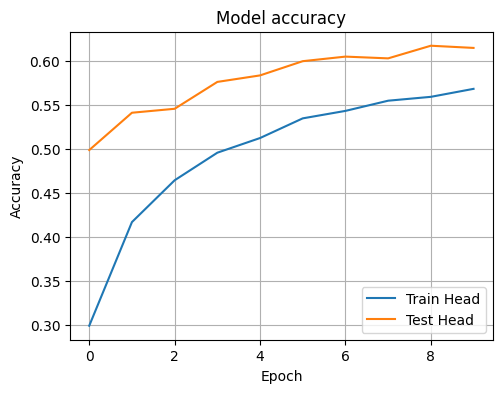

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_head.history['accuracy'])
plt.plot(history_head.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Head', 'Test Head'], loc='lower right')
plt.grid(True)

plt.show()

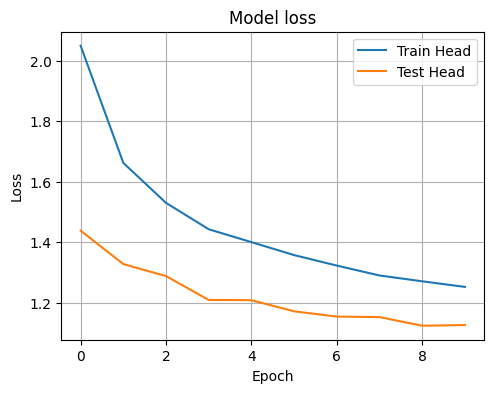

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history_head.history['loss'])
plt.plot(history_head.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Head', 'Test Head'], loc='upper right')
plt.grid(True)
plt.show()

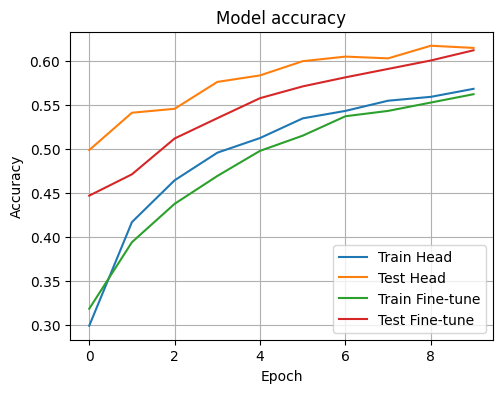

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_head.history['accuracy'])
plt.plot(history_head.history['val_accuracy'])
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Head', 'Test Head', 'Train Fine-tune', 'Test Fine-tune'], loc='lower right')
plt.grid(True)

plt.show()

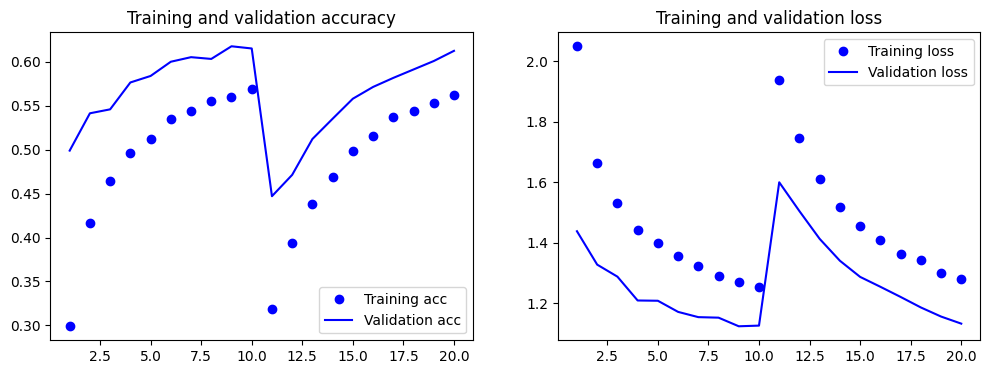

In [ ]:
#Combine history from phase 1 + phase 2
acc = history_head.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_head.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_head.history['loss'] + history_finetune.history['loss']
val_loss = history_head.history['val_loss'] + history_finetune.history['val_loss']

# epoch
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()